In [ ]:
!pip install scikit-learn pandas numpy matplotlib seaborn Sastrawi wordcloud
!pip install Sastrawi==1.0.1 --force-reinstall
import os, re, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import log_loss
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score, make_scorer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.3 MB/s eta 0:00:00
  Using cached Sastrawi-1.0.1-py2.py3-none-any.whl.metadata (909 bytes)
Using cached Sastrawi-1.0.1-py2.py3-none-any.whl (209 kB)
  Attempting uninstall: Sastrawi
    Found existing installation: Sastrawi 1.0.1
    Uninstalling Sastrawi-1.0.1:
      Successfully uninstalled Sastrawi-1.0.1


## DATA ACQUISITION

In [ ]:
# =========================================================
# LOAD DATA
# =========================================================
from google.colab import drive
drive.mount('/content/drive')

PATH_DATA = "/content/drive/MyDrive/DATAKU/email_spam_indo.csv"
df = pd.read_csv(PATH_DATA)
df = df.rename(columns={"Pesan":"email", "Kategori":"label"})

# CEK DUPLIKAT
print("Jumlah data sebelum hapus duplikat:", len(df))
print("Jumlah duplikat:", df.duplicated().sum())

before = df.shape[0]

dup_rows = df[df.duplicated(subset='email', keep='first')]
dup_dist = dup_rows['label'].value_counts()

df = df.drop_duplicates(subset='email')

after = df.shape[0]
print("Distribusi label duplikat yang dihapus:")
print(dup_dist)

# hapus duplikat
df = df.drop_duplicates(subset=['email'])
print("Jumlah data setelah hapus duplikat:", len(df))
print("Distribusi label:\n", df['label'].value_counts())

X = df['email']
y = df['label']

Mounted at /content/drive
Jumlah data sebelum hapus duplikat: 2636
Jumlah duplikat: 16
Distribusi label duplikat yang dihapus:
label
ham    16
Name: count, dtype: int64
Jumlah data setelah hapus duplikat: 2620
Distribusi label:
 label
spam    1368
ham     1252
Name: count, dtype: int64


## EDA DATA MENTAH

/tmp/ipython-input-1967255548.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


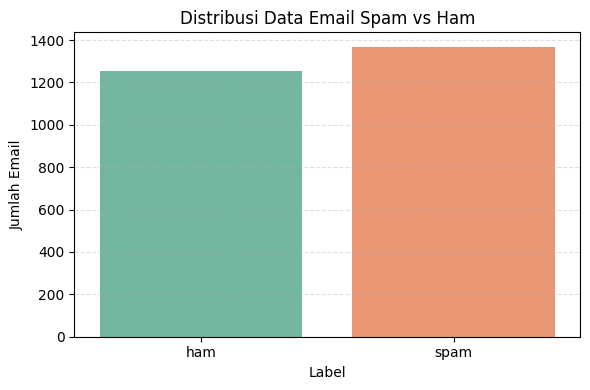

Distribusi label:
 label
spam    1368
ham     1252
Name: count, dtype: int64


In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(
    x="label",
    data=df,
    order=['ham', 'spam'],
    palette='Set2'
)

plt.title("Distribusi Data Email Spam vs Ham")
plt.xlabel("Label")
plt.ylabel("Jumlah Email")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

print("Distribusi label:\n", df['label'].value_counts())


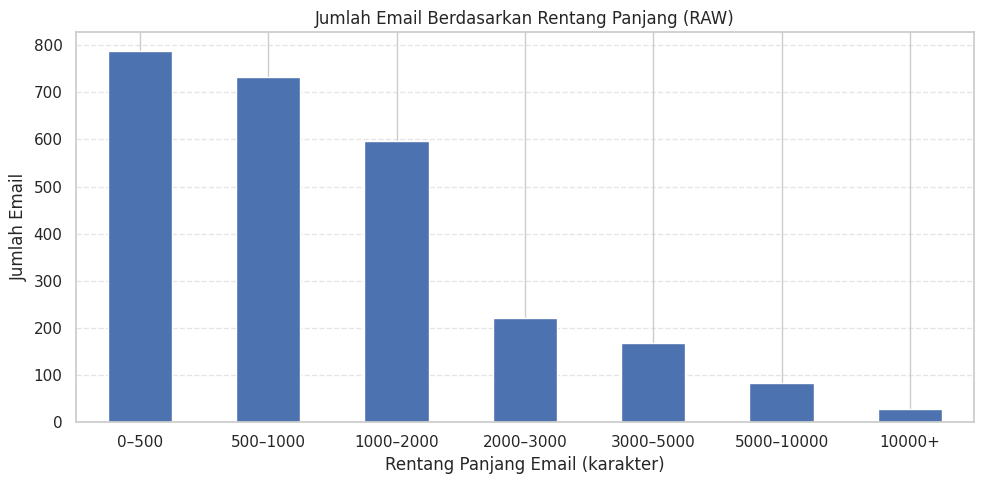

=== Jumlah Email per Rentang Panjang ===
length_bin
0–500         788
500–1000      732
1000–2000     597
2000–3000     222
3000–5000     169
5000–10000     84
10000+         28
Name: count, dtype: int64


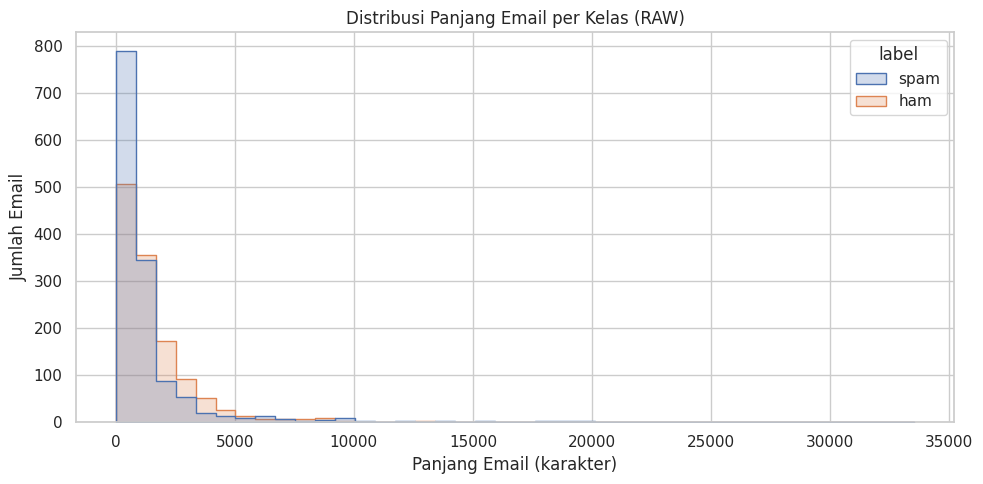


=== Jumlah Email per Rentang Panjang per Kelas ===
label  length_bin
ham    0–500         286
       500–1000      305
       1000–2000     354
       2000–3000     147
       3000–5000     109
       5000–10000     43
       10000+          8
spam   0–500         502
       500–1000      427
       1000–2000     243
       2000–3000      75
       3000–5000      60
       5000–10000     41
       10000+         20
Name: count, dtype: int64


In [ ]:
# =========================
# EDA PANJANG EMAIL (RAW)
# =========================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid")

# Gunakan dataframe utama
df_eda = df.copy()

# Hitung panjang email (RAW TEXT)
df_eda['email_length'] = df_eda['email'].astype(str).apply(len)

# Binning panjang email (bin terakhir terbuka)
bins = [0, 500, 1000, 2000, 3000, 5000, 10000, float('inf')]
labels = [
    "0–500", "500–1000", "1000–2000",
    "2000–3000", "3000–5000",
    "5000–10000", "10000+"
]

df_eda['length_bin'] = pd.cut(
    df_eda['email_length'],
    bins=bins,
    labels=labels
)

# =========================
# BAR CHART PER RENTANG
# =========================
plt.figure(figsize=(10,5))
df_eda['length_bin'].value_counts().sort_index().plot(kind='bar')
plt.title("Jumlah Email Berdasarkan Rentang Panjang (RAW)")
plt.xlabel("Rentang Panjang Email (karakter)")
plt.ylabel("Jumlah Email")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("=== Jumlah Email per Rentang Panjang ===")
print(df_eda['length_bin'].value_counts().sort_index())

# =========================
# HISTOGRAM PANJANG EMAIL PER KELAS
# =========================
plt.figure(figsize=(10,5))
sns.histplot(
    data=df_eda,
    x='email_length',
    hue='label',
    bins=40,
    kde=False,
    element='step'
)
plt.title("Distribusi Panjang Email per Kelas (RAW)")
plt.xlabel("Panjang Email (karakter)")
plt.ylabel("Jumlah Email")
plt.tight_layout()
plt.show()

print("\n=== Jumlah Email per Rentang Panjang per Kelas ===")
print(
    df_eda
    .groupby('label')['length_bin']
    .value_counts()
    .sort_index()
)


In [ ]:
# Hitung panjang email
df['email_length'] = df['email'].astype(str).str.len()

# Filter email <10 karakter
email_pendek = df[df['email_length'] < 15]

print("=== Email yang panjangnya <10 karakter ===")
print(email_pendek[['label', 'email_length', 'email']])


=== Email yang panjangnya <10 karakter ===
     label  email_length   email
568   spam             6  . JIF.
1990   ham             3     FYI


In [ ]:
MIN_LEN = 10
MAX_LEN = 10000

# Hitung panjang email
df['email_length'] = df['email'].astype(str).str.len()

# Email terhapus karena threshold bawah
hapus_bawah = df[df['email_length'] < MIN_LEN]

# Email terhapus karena threshold atas
hapus_atas = df[df['email_length'] > MAX_LEN]

print(f"Jumlah email terhapus karena threshold bawah (< {MIN_LEN}): {len(hapus_bawah)}")
print(f"Jumlah email terhapus karena threshold atas (> {MAX_LEN}): {len(hapus_atas)}")


Jumlah email terhapus karena threshold bawah (< 10): 2
Jumlah email terhapus karena threshold atas (> 10000): 28


In [ ]:
before = len(df)

df = df[
    (df['email_length'] >= MIN_LEN) &
    (df['email_length'] <= MAX_LEN)
].copy()

after = len(df)

print(f"Total email terhapus: {before - after}")

df.drop(columns=['email_length'], inplace=True)


Total email terhapus: 30


## DATA SPLIT

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train:", X_train.shape)
print("Test :", X_test.shape)
print("\nDistribusi label di data latih:\n", y_train.value_counts())

Train: (2096,)
Test : (524,)

Distribusi label di data latih:
 label
spam    1094
ham     1002
Name: count, dtype: int64


## DATA PREPROCESSING

In [ ]:
import unicodedata
import textwrap
import re
import nltk
from nltk.corpus import stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

nltk.download('stopwords')

# STOPWORD REMOVAL
stop_factory = StopWordRemoverFactory()
stopwords_id = set(stop_factory.get_stop_words()) # Sastrawi stopwords

# Stopword Inggris (NLTK)
stopwords_en = set(stopwords.words('english'))
# STEMMING
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

# KAMUS GAUL
df_kamus = pd.read_csv("/content/drive/MyDrive/DATAKU/kamus_gaul.csv")
kamus_normalisasi = dict(zip(df_kamus['slang'], df_kamus['formal']))

kamus_normalisasi["communications"] = "komunikasi"
kamus_normalisasi["university"] = "universitas"
kamus_normalisasi["mail"] = "email"
kamus_normalisasi["file"] = "berkas"
#Stopword tambahan
additional_stopwords = {
"gue", "viagra", "per",
"dpc", "nya", "sih",
"gas", "pana", "corp", "rice", "london","dear",
"faks", "ees", "lon", "jul","rxoo","gelling","epa"
}

stopwords_all = stopwords_id.union(stopwords_en).union(additional_stopwords)

def clean_text_model(text):

    # Hilangkan enter dan double enter
    text = text.replace("\n", " ")
    text = text.replace("\r", " ")
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\r+', ' ', text)

    # Case folding : mengubah teks menjadi huruf kecil
    text = str(text).lower()

    # Data cleaning : hapus URL dan email
    text = re.sub(r'\b(?:https?://|www\.|http\b|https\b)\S*|\S+@\S+\b', ' ', text)
    text = re.sub(r'\S+@\S+', ' ', text)

    # Data cleaning : hapus header email
    text = re.sub(r'\b(from|to|cc|bcc|subject|subjek|re|fw|fwd)\b', ' ', text)

    # Data cleaning : hapus domain email
    text = re.sub(r'\b(com|net|org|id|edu|inc|co)\b', ' ', text)

    # Data Cleaning
    text = re.sub(r'\b(enron|kaminski|vince|shirley|stinson|houston|hice|adobe|john|david|hou|crenshaw|stanford|ect|ee|eb|etc)\b', ' ', text, flags=re.IGNORECASE)

    # Remove Punctition : ganti underscore / dash unicode / tanda baca aneh jadi spasi
    text = re.sub(r'[_\-‐-―]+', ' ', text)

    # Remove Punctition : hapus karakter kontrol/invisible
    text = ''.join(ch for ch in text if not unicodedata.category(ch).startswith("C"))

    # Remove Punctition : hanya huruf dan spasi
    text = re.sub(r'[^a-z\s]', ' ', text)

    # Regex Penghapusan Huruf Berulang
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # Data Cleaning : hilangkan banyak spasi
    text = re.sub(r'\s+', ' ', text).strip()

    # tokenization : memecah teks menjadi kata-kata
    words = text.split()

    # Normalisasi Kata Slang
    words = [kamus_normalisasi.get(w, w) for w in words]

    # stemming : mengubah menjadi kata bentuk dasar
    words = [stemmer.stem(w) for w in words]

    # Stopword Removal : hapus kata-kata yang tidak bermakna
    words = [w for w in words if w not in stopwords_all] # This `stopwords` now correctly refers to the combined set
    words = [w for w in words if len(w) > 2]

    return " ".join(words)

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, kamus_normalisasi, stopwords_all, stemmer):
        self.kamus_normalisasi = kamus_normalisasi
        self.stopwords_all = stopwords_all
        self.stemmer = stemmer

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [clean_text_model(str(x)) for x in X]

preprocess = TextPreprocessor(kamus_normalisasi, stopwords_all, stemmer)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df_preview = pd.DataFrame({
    "Teks_Asli": X[:5],
    "Teks_Setelah_Preprocessing": preprocess.transform(X[:5])
})

df_preview

,Teks_Asli,Teks_Setelah_Preprocessing
0,Secara alami tak tertahankan identitas perusah...,cara alami tak tahan identitas usaha sangat su...
1,Fanny Gunslinger Perdagangan Saham adalah Merr...,fanny gunslinger dagang saham merrill muzo buk...
2,Rumah -rumah baru yang luar biasa menjadi muda...,rumah rumah baru luar biasa jadi mudah tunjuk ...
3,4 Permintaan Khusus Pencetakan Warna Informasi...,minta khusus cetak warna informasi tambah seka...
4,"Jangan punya uang, dapatkan CD perangkat lunak...",jangan punya uang celana dalam perangkat lunak...


## EXPLORATORY DATA ANALYSIS DATA BERSIH

In [ ]:
# Buat DataFrame EDA dari DATA LATIH
df_eda = pd.DataFrame({
    'email_raw': X_train.values,
    'label': y_train.values
})

df_eda['clean_text'] = preprocess.transform(df_eda['email_raw'])

/tmp/ipython-input-1360581165.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


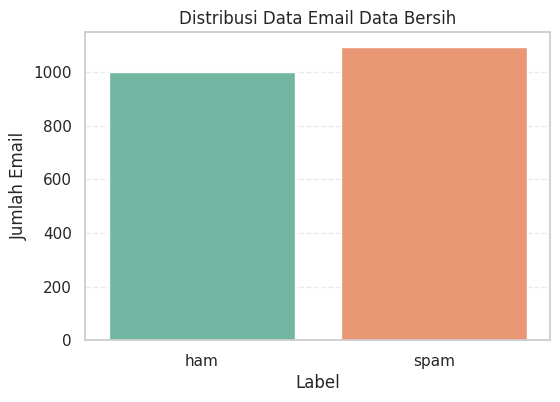

Distribusi label:
 label
spam    1094
ham     1002
Name: count, dtype: int64


In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(
    x='label',
    data=df_eda,
    palette='Set2'
)
plt.title("Distribusi Data Email Data Bersih")
plt.xlabel("Label")
plt.ylabel("Jumlah Email")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

print("Distribusi label:\n", df_eda['label'].value_counts())

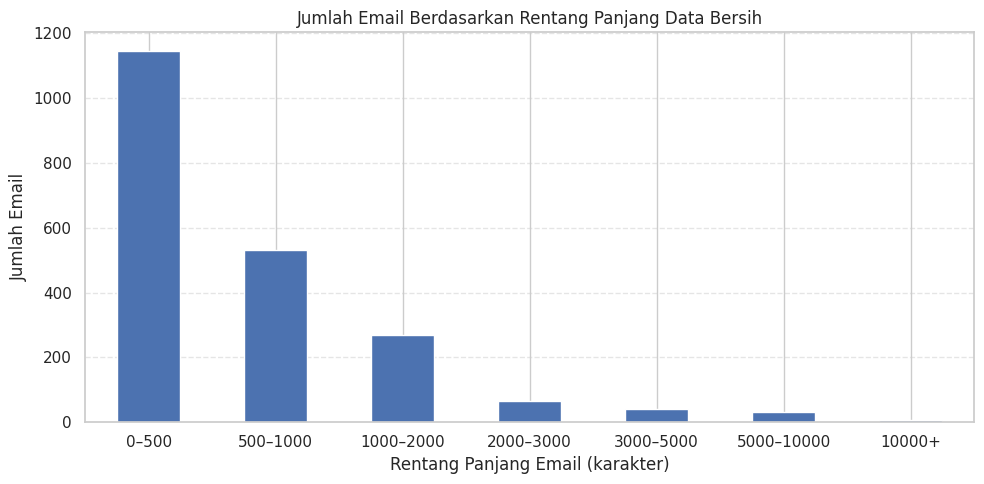

=== Jumlah Email per Rentang Panjang Data Bersih ===
length_bin
0–500         1146
500–1000       531
1000–2000      269
2000–3000       67
3000–5000       42
5000–10000      33
10000+           8
Name: count, dtype: int64


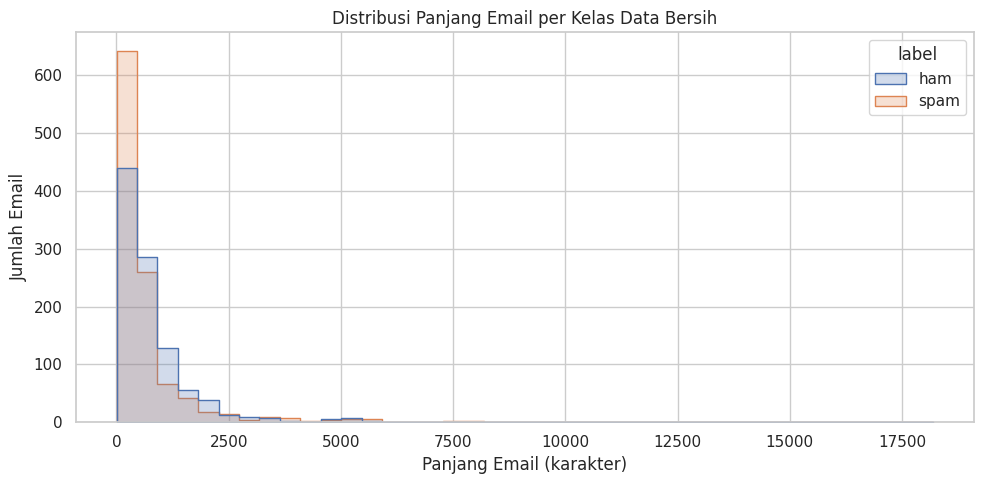


=== Jumlah Email per Rentang Panjang per Kelas Data Bersih ===
label  length_bin
ham    0–500         471
       500–1000      285
       1000–2000     169
       2000–3000      42
       3000–5000      20
       5000–10000     13
       10000+          2
spam   0–500         675
       500–1000      246
       1000–2000     100
       2000–3000      25
       3000–5000      22
       5000–10000     20
       10000+          6
Name: count, dtype: int64


In [ ]:
# =========================
# EDA PANJANG EMAIL (SETELAH PREPROCESSING - DATA LATIH)
# =========================

# Hitung panjang email dari CLEAN TEXT
df_eda['email_length'] = df_eda['clean_text'].astype(str).apply(len)

# BIN HARUS SAMA DENGAN EDA RAW & THRESHOLD
bins = [0, 500, 1000, 2000, 3000, 5000, 10000, float('inf')]
labels = [
    "0–500", "500–1000", "1000–2000",
    "2000–3000", "3000–5000",
    "5000–10000", "10000+"
]

df_eda['length_bin'] = pd.cut(
    df_eda['email_length'],
    bins=bins,
    labels=labels
)

# =========================
# BAR CHART PER RENTANG
# =========================
plt.figure(figsize=(10,5))
df_eda['length_bin'].value_counts().sort_index().plot(kind='bar')
plt.title("Jumlah Email Berdasarkan Rentang Panjang Data Bersih")
plt.xlabel("Rentang Panjang Email (karakter)")
plt.ylabel("Jumlah Email")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("=== Jumlah Email per Rentang Panjang Data Bersih ===")
print(df_eda['length_bin'].value_counts().sort_index())

# =========================
# HISTOGRAM PANJANG EMAIL PER KELAS
# =========================
plt.figure(figsize=(10,5))
sns.histplot(
    data=df_eda,
    x='email_length',
    hue='label',
    bins=40,
    kde=False,
    element='step'
)
plt.title("Distribusi Panjang Email per Kelas Data Bersih")
plt.xlabel("Panjang Email (karakter)")
plt.ylabel("Jumlah Email")
plt.tight_layout()
plt.show()

print("\n=== Jumlah Email per Rentang Panjang per Kelas Data Bersih ===")
print(
    df_eda
    .groupby('label')['length_bin']
    .value_counts()
    .sort_index()
)


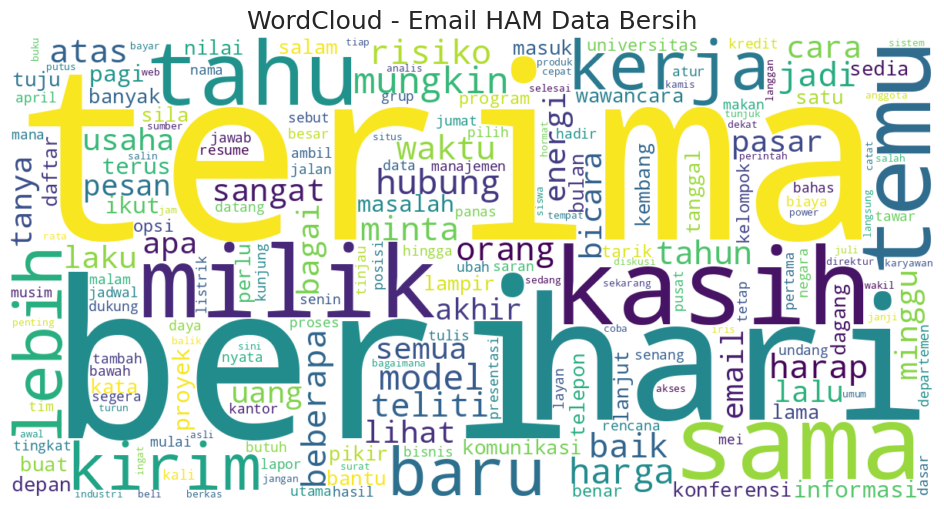

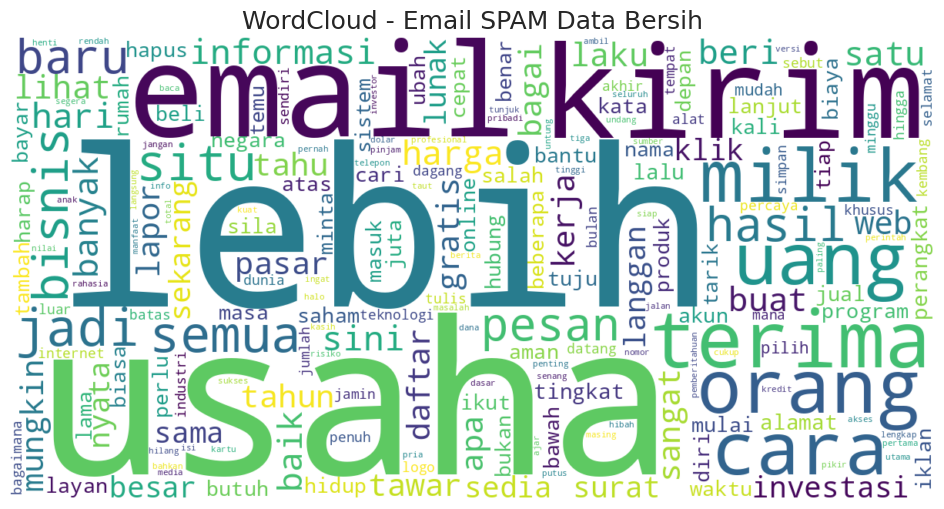

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# =====================================================
# WORDCLOUD MENGGUNAKAN HASIL PREPROCESSING (clean_text)
# =====================================================

for label in df_eda['label'].unique():

    text_label = " ".join(
        df_eda[df_eda['label'] == label]['clean_text']
        .dropna()
        .astype(str)
    )

    wc = WordCloud(
        width=1200,
        height=600,
        background_color='white',
        collocations=False,
        min_font_size=10
        # TIDAK pakai stopwords lagi
        # karena sudah dihapus saat preprocessing
    ).generate(text_label)

    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(
        f"WordCloud - Email {label.upper()} Data Bersih",
        fontsize=18
    )
    plt.show()



In [ ]:
tfidf_eda = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=2,
    max_df=0.9
)

tfidf_matrix = tfidf_eda.fit_transform(df_eda['clean_text'])
feature_names = tfidf_eda.get_feature_names_out()

ham_idx = df_eda.index[df_eda['label'] == 'ham'].tolist()
spam_idx = df_eda.index[df_eda['label'] == 'spam'].tolist()

# ANALISIS HAM
tfidf_ham_matrix = tfidf_matrix[ham_idx]

num_docs_ham = tfidf_ham_matrix.shape[0]  # jumlah dokumen HAM
unique_words_ham = np.sum(tfidf_ham_matrix.toarray() > 0, axis=0)
num_unique_ham = np.sum(unique_words_ham > 0)
avg_tfidf_ham = tfidf_ham_matrix.mean()

# Rata-rata tf-idf ham
avg_tfidf_ham_per_word = np.array(tfidf_ham_matrix.mean(axis=0)).flatten()
tfidf_dict_ham = dict(zip(feature_names, avg_tfidf_ham_per_word))
tfidf_sorted_ham = dict(sorted(tfidf_dict_ham.items(), key=lambda x: x[1], reverse=True))

# Top 10 kata TF-IDF HAM
top_n = 5
df_top_ham = pd.DataFrame({
    'Kata': list(tfidf_sorted_ham.keys())[:top_n],
    'Rata2_TF_IDF': list(tfidf_sorted_ham.values())[:top_n]
})

# ANALISIS SPAM
tfidf_spam_matrix = tfidf_matrix[spam_idx]

num_docs_spam = tfidf_spam_matrix.shape[0]  # jumlah dokumen SPAM
unique_words_spam = np.sum(tfidf_spam_matrix.toarray() > 0, axis=0)
num_unique_spam = np.sum(unique_words_spam > 0)
avg_tfidf_spam = tfidf_spam_matrix.mean()

# rata-rata TF-IDF tiap kata
avg_tfidf_spam_per_word = np.array(tfidf_spam_matrix.mean(axis=0)).flatten()
tfidf_dict_spam = dict(zip(feature_names, avg_tfidf_spam_per_word))
tfidf_sorted_spam = dict(sorted(tfidf_dict_spam.items(), key=lambda x: x[1], reverse=True))

# Top 10 kata TF-IDF SPAM
df_top_spam = pd.DataFrame({
    'Kata': list(tfidf_sorted_spam.keys())[:top_n],
    'Rata2_TF_IDF': list(tfidf_sorted_spam.values())[:top_n]
})

print("=== DATA TF-IDF HAM & SPAM (EDA) ===")
print(f"Jumlah dokumen HAM (row TF-IDF): {num_docs_ham}")
print(f"Jumlah dokumen SPAM (row TF-IDF): {num_docs_spam}\n")

print(f"Jumlah kata unik HAM: {num_unique_ham}")
print(f"Jumlah kata unik SPAM: {num_unique_spam}\n")

print(f"Rata-rata TF-IDF HAM: {avg_tfidf_ham}")
print(f"Rata-rata TF-IDF SPAM: {avg_tfidf_spam}\n")

print("Top 10 kata TF-IDF HAM:")
print(df_top_ham)
print("\nTop 10 kata TF-IDF SPAM:")
print(df_top_spam)


=== DATA TF-IDF HAM & SPAM (EDA) ===
Jumlah dokumen HAM (row TF-IDF): 1002
Jumlah dokumen SPAM (row TF-IDF): 1094

Jumlah kata unik HAM: 26142
Jumlah kata unik SPAM: 25461

Rata-rata TF-IDF HAM: 0.0002138618099288879
Rata-rata TF-IDF SPAM: 0.00021946425106444416

Top 10 kata TF-IDF HAM:
           Kata  Rata2_TF_IDF
0        terima      0.025127
1  terima kasih      0.023698
2         kasih      0.023676
3          beri      0.019813
4          temu      0.019281

Top 10 kata TF-IDF SPAM:
    Kata  Rata2_TF_IDF
0  situs      0.023577
1  lebih      0.023325
2  lunak      0.020494
3  email      0.020481
4  kirim      0.020067


## TF IDF

In [ ]:
tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=2,
    max_df=0.9,
    max_features=6000,
    sublinear_tf=True,
    smooth_idf=True,
    norm='l2'
)

Top TF-IDF Words:
terima: 0.026
lebih: 0.023
kirim: 0.021
milik: 0.021
hari: 0.021
beri: 0.019
orang: 0.019
tahu: 0.019
baik: 0.019
email: 0.019

DataFrame Top TF-IDF:
     Kata  Nilai_TF_IDF
0  terima      0.025841
1   lebih      0.022542
2   kirim      0.021110
3   milik      0.020962
4    hari      0.020554
5    beri      0.019395
6   orang      0.019213
7    tahu      0.019120
8    baik      0.019108
9   email      0.018899


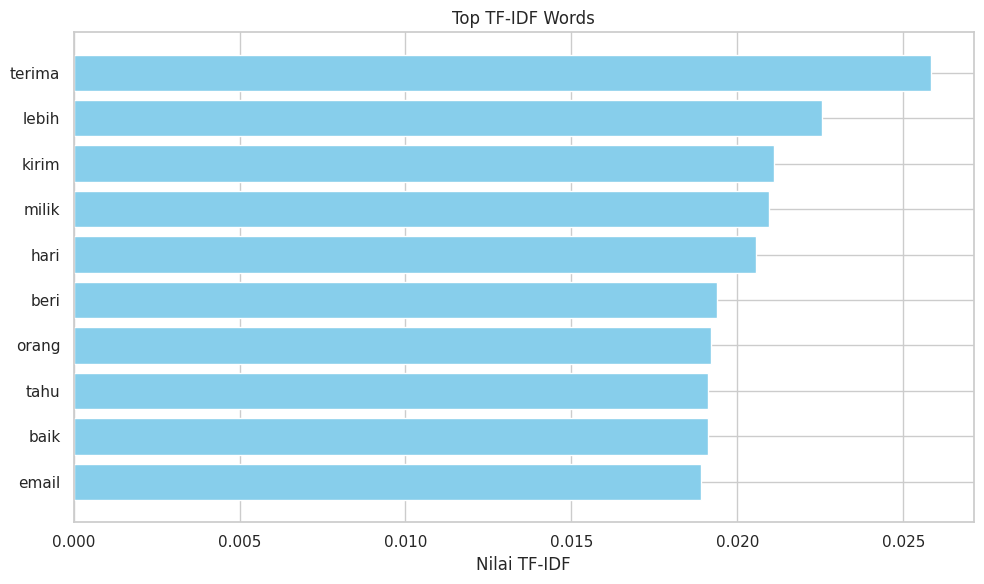

In [ ]:
# Fit dan transformasi data
tfidf_matrix = tfidf.fit_transform(df_eda['clean_text'])

# Ambil daftar kata / fitur
feature_names = tfidf.get_feature_names_out()

# Hitung rata-rata TF-IDF setiap kata di seluruh dokumen
avg_tfidf = np.array(tfidf_matrix.mean(axis=0)).flatten()

# Buat dictionary kata -> nilai TF-IDF
tfidf_dict = dict(zip(feature_names, avg_tfidf))

# Urutkan dari nilai tertinggi
tfidf_sorted = dict(sorted(tfidf_dict.items(), key=lambda x: x[1], reverse=True))

# Tampilkan 10 kata dengan TF-IDF tertinggi
top_n = 10
print("Top TF-IDF Words:")
for word, score in list(tfidf_sorted.items())[:top_n]:
    print(f"{word}: {score:.3f}")

# Simpan ke DataFrame (untuk tabel di skripsi)
df_tfidf = pd.DataFrame({
    'Kata': list(tfidf_sorted.keys())[:top_n],
    'Nilai_TF_IDF': list(tfidf_sorted.values())[:top_n]
})

print("\nDataFrame Top TF-IDF:")
print(df_tfidf)

# Visualisasi Top TF-IDF
plt.figure(figsize=(10,6))
plt.barh(df_tfidf['Kata'][::-1], df_tfidf['Nilai_TF_IDF'][::-1], color='skyblue')
plt.xlabel("Nilai TF-IDF")
plt.title("Top TF-IDF Words")
plt.tight_layout()
plt.show()

## PIPELINE

In [ ]:
pipeline_nb = Pipeline([
    ('preprocess', preprocess),
    ('tfidf', tfidf),
    ('model', MultinomialNB())
])

pipeline_svm = Pipeline([
    ('preprocess', preprocess),
    ('tfidf', tfidf),
    ('model', SVC())
])

## MODELLING

In [ ]:
import time
def evaluate_pipeline(name, pipeline):
    print(f"\n=== {name} ===")
    start_train = time.time()
    pipeline.fit(X_train, y_train)
    train_time = time.time() - start_train

    start_test = time.time()
    y_pred = pipeline.predict(X_test)
    test_time = time.time() - start_test

    print("Precision (Spam) :", precision_score(y_test, y_pred, pos_label='spam'))
    print("Recall    (Spam) :", recall_score(y_test, y_pred, pos_label='spam'))
    print("F1-Score  (Spam) :", f1_score(y_test, y_pred, pos_label='spam'))
    print("Accuracy         :", accuracy_score(y_test, y_pred))
    print("Training Time    :", train_time)
    print("Testing Time     :", test_time)
    print("\nDetail:")
    print(classification_report(y_test, y_pred, zero_division=0))

    return {
        "Model": name,
        "Precision_spam": precision_score(y_test, y_pred, pos_label='spam'),
        "Recall_spam": recall_score(y_test, y_pred, pos_label='spam'),
        "F1_spam": f1_score(y_test, y_pred, pos_label='spam'),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Train_time": train_time,
        "Test_time": test_time
    }


In [ ]:
results_baseline = []
results_baseline.append(evaluate_pipeline("Naive Bayes (Baseline)", pipeline_nb))
results_baseline.append(evaluate_pipeline("SVM (Baseline)", pipeline_svm))
baseline_df = pd.DataFrame(results_baseline)
display(baseline_df)



=== Naive Bayes (Baseline) ===
Precision (Spam) : 0.9816849816849816
Recall    (Spam) : 0.9781021897810219
F1-Score  (Spam) : 0.979890310786106
Accuracy         : 0.9790076335877863
Training Time    : 10.406935453414917
Testing Time     : 323.04725766181946

Detail:
              precision    recall  f1-score   support

         ham       0.98      0.98      0.98       250
        spam       0.98      0.98      0.98       274

    accuracy                           0.98       524
   macro avg       0.98      0.98      0.98       524
weighted avg       0.98      0.98      0.98       524


=== SVM (Baseline) ===
Precision (Spam) : 0.9642857142857143
Recall    (Spam) : 0.9854014598540146
F1-Score  (Spam) : 0.9747292418772563
Accuracy         : 0.9732824427480916
Training Time    : 10.079861640930176
Testing Time     : 1.5951378345489502

Detail:
              precision    recall  f1-score   support

         ham       0.98      0.96      0.97       250
        spam       0.96      0.99  

,Model,Precision_spam,Recall_spam,F1_spam,Accuracy,Train_time,Test_time
0,Naive Bayes (Baseline),0.981685,0.978102,0.979890,0.979008,10.406935,323.047258
1,SVM (Baseline),0.964286,0.985401,0.974729,0.973282,10.079862,1.595138


## HYPERPARAMETER TUNING

In [ ]:
f1_spam = make_scorer(f1_score, pos_label='spam')

param_nb = {'model__alpha':[0.1, 0.5, 1.0]}
grid_nb = GridSearchCV(pipeline_nb, param_nb, cv=3, scoring=f1_spam, n_jobs=-1)

start = time.time()
grid_nb.fit(X_train, y_train)
tune_nb = time.time() - start

best_nb = grid_nb.best_estimator_

pipeline_svm_tuned = Pipeline([
    ('preprocess', preprocess),
    ('tfidf', tfidf),
    ('model', SVC(probability=True, random_state=42))
])

param_svm = [
    {'model__kernel':['linear'],  'model__C':[0.1,1], 'model__class_weight':[None,'balanced']},
    {'model__kernel':['rbf'],     'model__C':[0.1,1], 'model__gamma':['scale'], 'model__class_weight':[None,'balanced']},
    {'model__kernel':['poly'],    'model__C':[0.1,1], 'model__degree':[2], 'model__gamma':['scale'], 'model__coef0':[0], 'model__class_weight':[None,'balanced']},
    {'model__kernel':['sigmoid'], 'model__C':[0.1,1], 'model__gamma':['scale'], 'model__coef0':[0], 'model__class_weight':[None,'balanced']}
]

grid_svm = GridSearchCV(pipeline_svm_tuned, param_svm, cv=3, scoring=f1_spam, n_jobs=-1)

start = time.time()
grid_svm.fit(X_train, y_train)
tune_svm = time.time() - start

best_svm = grid_svm.best_estimator_

print("NB tuning time:", tune_nb)
print("Best NB params:", grid_nb.best_params_)
print("SVM tuning time:", tune_svm)
print("Best SVM params:", grid_svm.best_params_)

NB tuning time: 60.88850665092468
Best NB params: {'model__alpha': 0.5}
SVM tuning time: 554.3515033721924
Best SVM params: {'model__C': 1, 'model__class_weight': None, 'model__gamma': 'scale', 'model__kernel': 'rbf'}


In [ ]:
results_tuned = []
results_tuned.append(evaluate_pipeline("Naive Bayes (Tuned)", best_nb))
results_tuned.append(evaluate_pipeline("SVM (Tuned)", best_svm))
tuned_df = pd.DataFrame(results_tuned)
display(tuned_df)



=== Naive Bayes (Tuned) ===
Precision (Spam) : 0.988929889298893
Recall    (Spam) : 0.9781021897810219
F1-Score  (Spam) : 0.9834862385321101
Accuracy         : 0.982824427480916
Training Time    : 5.483068943023682
Testing Time     : 1.1390471458435059

Detail:
              precision    recall  f1-score   support

         ham       0.98      0.99      0.98       250
        spam       0.99      0.98      0.98       274

    accuracy                           0.98       524
   macro avg       0.98      0.98      0.98       524
weighted avg       0.98      0.98      0.98       524


=== SVM (Tuned) ===
Precision (Spam) : 0.9642857142857143
Recall    (Spam) : 0.9854014598540146
F1-Score  (Spam) : 0.9747292418772563
Accuracy         : 0.9732824427480916
Training Time    : 22.88877582550049
Testing Time     : 1.6183984279632568

Detail:
              precision    recall  f1-score   support

         ham       0.98      0.96      0.97       250
        spam       0.96      0.99      0.97 

,Model,Precision_spam,Recall_spam,F1_spam,Accuracy,Train_time,Test_time
0,Naive Bayes (Tuned),0.988930,0.978102,0.983486,0.982824,5.483069,1.139047
1,SVM (Tuned),0.964286,0.985401,0.974729,0.973282,22.888776,1.618398


In [ ]:
pipeline_svm_baseline_soft = Pipeline([
    ('preprocess', preprocess),
    ('tfidf', tfidf),
    ('model', SVC(probability=True))  # hanya untuk soft voting
])

In [ ]:
ensemble_hard_baseline = VotingClassifier(
    estimators=[
        ('nb', pipeline_nb),
        ('svm', pipeline_svm)
    ],
    voting='hard'
)
ensemble_soft_baseline = VotingClassifier(
    estimators=[
        ('nb', pipeline_nb),
        ('svm', pipeline_svm_baseline_soft)
    ],
    voting='soft'
)


In [ ]:
ensemble_hard_tuned = VotingClassifier(
    estimators=[
        ('nb', best_nb),
        ('svm', best_svm)
    ],
    voting='hard'
)
ensemble_soft_tuned = VotingClassifier(
    estimators=[
        ('nb', best_nb),
        ('svm', best_svm)
    ],
    voting='soft'
)

In [ ]:
results = []

# Baseline
results.append(evaluate_pipeline("NB Baseline", pipeline_nb))
results.append(evaluate_pipeline("SVM Baseline", pipeline_svm))

# Ensemble Baseline
results.append(evaluate_pipeline("Ensemble Hard Baseline", ensemble_hard_baseline))
results.append(evaluate_pipeline("Ensemble Soft Baseline", ensemble_soft_baseline))

# Tuned
results.append(evaluate_pipeline("NB Tuned", best_nb))
results.append(evaluate_pipeline("SVM Tuned", best_svm))

# Ensemble Tuned
results.append(evaluate_pipeline("Ensemble Hard Tuned", ensemble_hard_tuned))
results.append(evaluate_pipeline("Ensemble Soft Tuned", ensemble_soft_tuned))

df_results = pd.DataFrame(results)
df_results


=== NB Baseline ===
Precision (Spam) : 0.9816849816849816
Recall    (Spam) : 0.9781021897810219
F1-Score  (Spam) : 0.979890310786106
Accuracy         : 0.9790076335877863
Training Time    : 5.842665433883667
Testing Time     : 1.1331779956817627

Detail:
              precision    recall  f1-score   support

         ham       0.98      0.98      0.98       250
        spam       0.98      0.98      0.98       274

    accuracy                           0.98       524
   macro avg       0.98      0.98      0.98       524
weighted avg       0.98      0.98      0.98       524


=== SVM Baseline ===
Precision (Spam) : 0.9642857142857143
Recall    (Spam) : 0.9854014598540146
F1-Score  (Spam) : 0.9747292418772563
Accuracy         : 0.9732824427480916
Training Time    : 10.04962158203125
Testing Time     : 1.6204822063446045

Detail:
              precision    recall  f1-score   support

         ham       0.98      0.96      0.97       250
        spam       0.96      0.99      0.97       

,Model,Precision_spam,Recall_spam,F1_spam,Accuracy,Train_time,Test_time
0,NB Baseline,0.981685,0.978102,0.979890,0.979008,5.842665,1.133178
1,SVM Baseline,0.964286,0.985401,0.974729,0.973282,10.049622,1.620482
2,Ensemble Hard Baseline,0.981685,0.978102,0.979890,0.979008,16.096060,2.780298
3,Ensemble Soft Baseline,0.971223,0.985401,0.978261,0.977099,28.953691,4.552052
4,NB Tuned,0.988930,0.978102,0.983486,0.982824,5.465532,1.122369
5,SVM Tuned,0.964286,0.985401,0.974729,0.973282,22.847471,1.600007
6,Ensemble Hard Tuned,0.988930,0.978102,0.983486,0.982824,28.357733,2.716439
7,Ensemble Soft Tuned,0.974729,0.985401,0.980036,0.979008,28.215702,2.751668


## ROC AUC

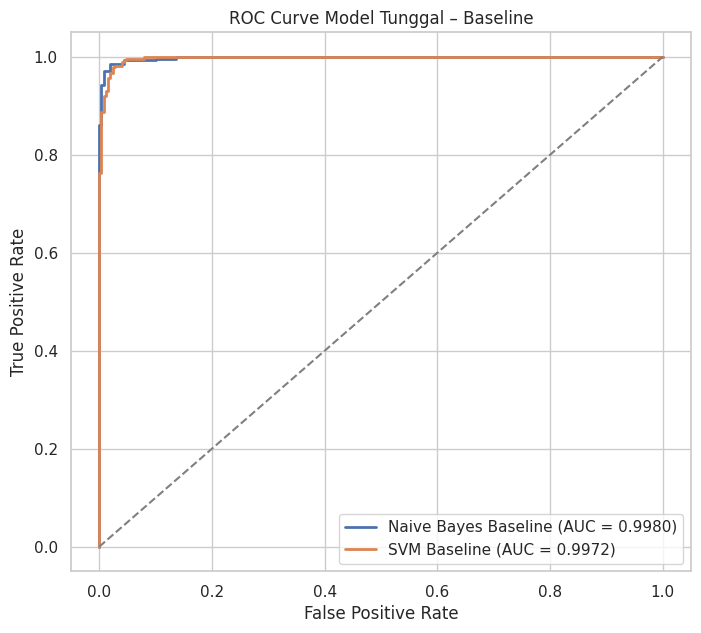

In [ ]:
models_single_baseline = {
    "Naive Bayes Baseline": pipeline_nb,
    "SVM Baseline": pipeline_svm
}

plt.figure(figsize=(8, 7))

for name, model in models_single_baseline.items():
    y_score = get_score(model, X_test)
    fpr, tpr, _ = roc_curve(y_test_bin, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Model Tunggal – Baseline')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


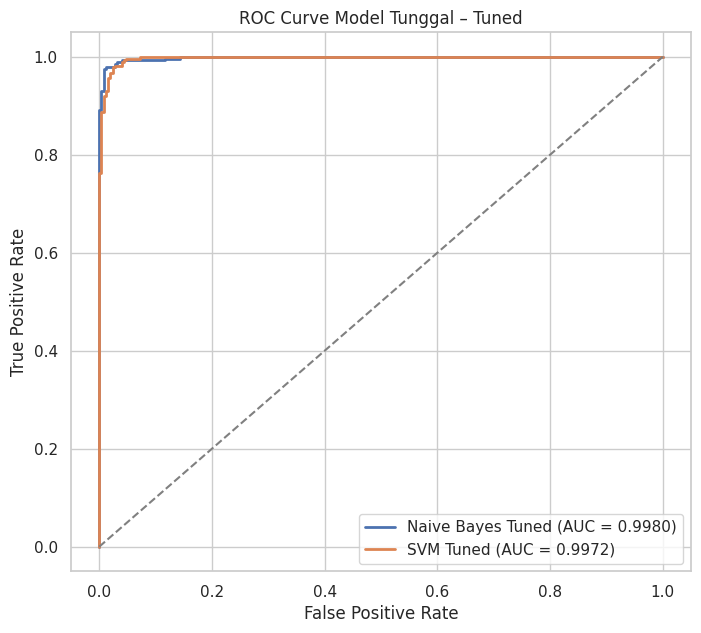

In [ ]:
models_single_tuned = {
    "Naive Bayes Tuned": best_nb,
    "SVM Tuned": best_svm
}

plt.figure(figsize=(8, 7))

for name, model in models_single_tuned.items():
    y_score = get_score(model, X_test)
    fpr, tpr, _ = roc_curve(y_test_bin, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Model Tunggal – Tuned')
plt.legend(loc='lower right')
plt.grid(True)
plt.grid(True)
plt.show()


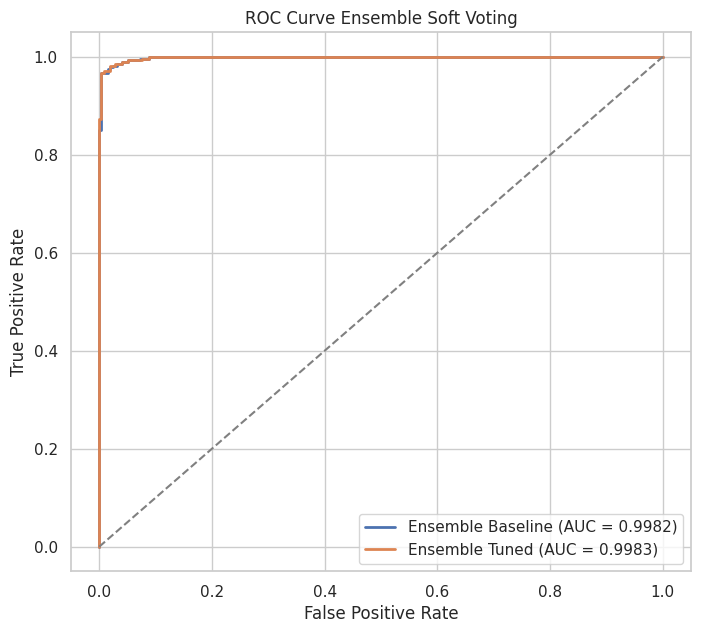

In [ ]:
models_ensemble = {
    "Ensemble Baseline": ensemble_soft_baseline,
    "Ensemble Tuned": ensemble_soft_tuned
}

plt.figure(figsize=(8, 7))

for name, model in models_ensemble.items():
    y_score = get_score(model, X_test)
    fpr, tpr, _ = roc_curve(y_test_bin, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Ensemble Soft Voting')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
# ===========================
# Eksperimen TF-IDF (cek parameter paling berpengaruh)
# ===========================

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# ===========================
# 1. Gunakan data yang sudah bersih/preprocessed
# ===========================
# Ganti 'CleanTextColumn' dengan nama kolom teks yang sudah dibersihkan
df_clean = df.copy()

# Apply preprocessing to create 'clean_text' column
df_clean['clean_text'] = preprocess.transform(df_clean['email'])

text_column = 'clean_text'

# ===========================
# 2. Konfigurasi default TF-IDF (sesuai Tabel 4.12)
# ===========================
default_params = {
    'ngram_range': (1,2),
    'min_df': 2,
    'max_df': 0.9,
    'max_features': 6000,
    'sublinear_tf': True,
    'smooth_idf': True,
    'norm': 'l2'
}

# ===========================
# 3. Fungsi untuk eksperimen satu parameter
# ===========================
def test_parameter(name, values):
    print(f"\n=== Mengecek pengaruh parameter: {name} ===")
    for val in values:
        # Salin default
        params = default_params.copy()
        # Ganti parameter yang diuji
        params[name] = val

        tfidf = TfidfVectorizer(**params)
        X_tfidf = tfidf.fit_transform(df_clean[text_column])

        # Rata-rata TF-IDF semua kata
        tfidf_means = np.array(X_tfidf.mean(axis=0)).flatten()
        avg_tfidf = tfidf_means.mean()

        print(f"{name}={val} | rata-rata TF-IDF: {avg_tfidf:.5f}")

# ===========================
# 4. Daftar parameter yang diuji
# ===========================
experiments = {
    'ngram_range': [(1,1), (1,2)],
    'min_df': [1,2],
    'max_df': [0.8,0.9],
    'max_features': [4000,6000],
    'sublinear_tf': [True, False],
    'smooth_idf': [True, False],
    'norm': ['l1','l2']
}

# ===========================
# 5. Jalankan eksperimen
# ===========================
for param_name, param_values in experiments.items():
    test_parameter(param_name, param_values)

# ===========================
# 6. Insight 10 kata teratas TF-IDF (untuk referensi)
# ===========================
tfidf = TfidfVectorizer(**default_params)
X_tfidf = tfidf.fit_transform(df_clean[text_column])

tfidf_means = np.array(X_tfidf.mean(axis=0)).flatten()
terms = np.array(tfidf.get_feature_names_out())
top_indices = tfidf_means.argsort()[::-1][:10]

print("\n10 kata teratas TF-IDF (rata-rata):")
for idx in top_indices:
    print(f"{terms[idx]}: {tfidf_means[idx]:.4f}")


=== Mengecek pengaruh parameter: ngram_range ===
ngram_range=(1, 1) | rata-rata TF-IDF: 0.00112
ngram_range=(1, 2) | rata-rata TF-IDF: 0.00128

=== Mengecek pengaruh parameter: min_df ===
min_df=1 | rata-rata TF-IDF: 0.00128
min_df=2 | rata-rata TF-IDF: 0.00128

=== Mengecek pengaruh parameter: max_df ===
max_df=0.8 | rata-rata TF-IDF: 0.00128
max_df=0.9 | rata-rata TF-IDF: 0.00128

=== Mengecek pengaruh parameter: max_features ===
max_features=4000 | rata-rata TF-IDF: 0.00184
max_features=6000 | rata-rata TF-IDF: 0.00128

=== Mengecek pengaruh parameter: sublinear_tf ===
sublinear_tf=True | rata-rata TF-IDF: 0.00128
sublinear_tf=False | rata-rata TF-IDF: 0.00116

=== Mengecek pengaruh parameter: smooth_idf ===
smooth_idf=True | rata-rata TF-IDF: 0.00128
smooth_idf=False | rata-rata TF-IDF: 0.00128

=== Mengecek pengaruh parameter: norm ===
norm=l1 | rata-rata TF-IDF: 0.00017
norm=l2 | rata-rata TF-IDF: 0.00128

10 kata teratas TF-IDF (rata-rata):
terima: 0.0253
lebih: 0.0223
kirim: 0

## LOG LOSS

In [ ]:
cv3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# SEMUA MODEL (boleh banyak)
all_models = {
    "Naive Bayes Baseline": pipeline_nb,
    "SVM Baseline": pipeline_svm,
    "Hard Voting Baseline": ensemble_hard_baseline,
    "Soft Voting Baseline": ensemble_soft_baseline,
    "Naive Bayes Tuned": best_nb,
    "SVM Tuned": best_svm,
    "Hard Voting Tuned": ensemble_hard_tuned,
    "Soft Voting Tuned": ensemble_soft_tuned
}

logloss_results = []

for name, model in all_models.items():
    # cek apakah model punya predict_proba
    if not hasattr(model, "predict_proba"):
        continue

    fold_losses = []

    for train_idx, val_idx in cv3.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model_clone = clone(model)
        model_clone.fit(X_tr, y_tr)

        y_prob = model_clone.predict_proba(X_val)

        fold_losses.append(
            log_loss(y_val, y_prob, labels=model_clone.classes_)
        )

    logloss_results.append({
        "Model": name,
        "LogLoss_Mean": np.mean(fold_losses),
        "LogLoss_STD": np.std(fold_losses)
    })

logloss_df = pd.DataFrame(logloss_results)
display(logloss_df.sort_values(by="LogLoss_Mean"))

,Model,LogLoss_Mean,LogLoss_STD
3,SVM Tuned,0.053644,0.003310
4,Soft Voting Tuned,0.060827,0.004496
1,Soft Voting Baseline,0.072835,0.004024
2,Naive Bayes Tuned,0.082392,0.003789
0,Naive Bayes Baseline,0.108367,0.003337


In [ ]:
f1_spam = make_scorer(f1_score, pos_label='spam')
cv3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [ ]:
models = {
    "NB Baseline": pipeline_nb,
    "SVM Baseline": pipeline_svm,
    "NB Tuned": best_nb,
    "SVM Tuned": best_svm,
    "Ensemble Hard Baseline": ensemble_hard_baseline,
    "Ensemble Soft Baseline": ensemble_soft_baseline,
    "Ensemble Hard Tuned": ensemble_hard_tuned,
    "Ensemble Soft Tuned": ensemble_soft_tuned
}


## STANDAR DEVIASI - STABILITASI

In [ ]:
cv_results = []

for name, model in models.items():
    scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=cv3,
        scoring=f1_spam,
        n_jobs=-1
    )

    cv_results.append({
        "Model": name,
        "Mean_F1_CV5": scores.mean(),
        "Std_F1_CV5": scores.std()
    })

    print(f"\n{name}")
    print("F1 per fold :", scores)
    print("Mean F1     :", scores.mean())
    print("Std Dev F1  :", scores.std())



NB Baseline
F1 per fold : [0.98076923 0.98630137 0.97925311]
Mean F1     : 0.9821079042218132
Std Dev F1  : 0.0030291384438908982

SVM Baseline
F1 per fold : [0.97948016 0.98907104 0.98486933]
Mean F1     : 0.9844735094691006
Std Dev F1  : 0.003925448552575317

NB Tuned
F1 per fold : [0.98076923 0.98630137 0.97925311]
Mean F1     : 0.9821079042218132
Std Dev F1  : 0.0030291384438908982

SVM Tuned
F1 per fold : [0.97948016 0.98907104 0.98486933]
Mean F1     : 0.9844735094691006
Std Dev F1  : 0.003925448552575317

Ensemble Hard Baseline
F1 per fold : [0.97931034 0.9862259  0.97777778]
Mean F1     : 0.9811046726407228
Std Dev F1  : 0.003674904235854229

Ensemble Soft Baseline
F1 per fold : [0.98356164 0.99180328 0.9862259 ]
Mean F1     : 0.9871969392803152
Std Dev F1  : 0.0034339802995426673

Ensemble Hard Tuned
F1 per fold : [0.97931034 0.9862259  0.97777778]
Mean F1     : 0.9811046726407228
Std Dev F1  : 0.003674904235854229

Ensemble Soft Tuned
F1 per fold : [0.98071625 0.9904502  0.9

In [ ]:
# === TRAIN FINAL MODEL TERBAIK ===
best_model_name = max(cv_results, key=lambda x: x["Mean_F1_CV5"])["Model"]
best_model = models[best_model_name]

print("Model terbaik berdasarkan CV:", best_model_name)

best_model.fit(X_train, y_train)

# === EVALUASI DATA TEST ===
y_pred_test = best_model.predict(X_test)

from sklearn.metrics import classification_report, f1_score

print("\n=== HASIL EVALUASI DATA TEST ===")
print(classification_report(y_test, y_pred_test))

# F1-score yang BENAR untuk label string
print("F1-score Test (macro)   :", f1_score(y_test, y_pred_test, average='macro'))
print("F1-score Test (weighted):", f1_score(y_test, y_pred_test, average='weighted'))

# Jika ingin F1 khusus kelas spam
print("F1-score Test (spam)    :", f1_score(y_test, y_pred_test, pos_label='spam'))


Model terbaik berdasarkan CV: Ensemble Soft Baseline

=== HASIL EVALUASI DATA TEST ===
              precision    recall  f1-score   support

         ham       0.98      0.97      0.97       250
        spam       0.97      0.98      0.98       274

    accuracy                           0.98       524
   macro avg       0.98      0.97      0.98       524
weighted avg       0.98      0.98      0.98       524

F1-score Test (macro)   : 0.9751247959627092
F1-score Test (weighted): 0.9751835015022178
F1-score Test (spam)    : 0.9764065335753176


In [ ]:
from google.colab import drive
import joblib, os

drive.mount('/content/drive')

SAVE_DIR = "/content/drive/MyDrive/PENTING/model_3"
os.makedirs(SAVE_DIR, exist_ok=True)

models_to_save = {
    # Baseline
    "pipeline_nb_baseline.pkl": pipeline_nb,
    "pipeline_svm_baseline.pkl": pipeline_svm,

    # Tuned
    "pipeline_nb_tuned.pkl": best_nb,
    "pipeline_svm_tuned.pkl": best_svm,

    # Ensemble
    "ensemble_hard_baseline.pkl": ensemble_hard_baseline,
    "ensemble_soft_baseline.pkl": ensemble_soft_baseline,
    "ensemble_hard_tuned.pkl": ensemble_hard_tuned,
    "ensemble_soft_tuned.pkl": ensemble_soft_tuned,
}

for name, model in models_to_save.items():
    path = os.path.join(SAVE_DIR, name)
    joblib.dump(model, path)
    print(f"✅ Saved: {path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Saved: /content/drive/MyDrive/PENTING/model_3/pipeline_nb_baseline.pkl
✅ Saved: /content/drive/MyDrive/PENTING/model_3/pipeline_svm_baseline.pkl
✅ Saved: /content/drive/MyDrive/PENTING/model_3/pipeline_nb_tuned.pkl
✅ Saved: /content/drive/MyDrive/PENTING/model_3/pipeline_svm_tuned.pkl
✅ Saved: /content/drive/MyDrive/PENTING/model_3/ensemble_hard_baseline.pkl
✅ Saved: /content/drive/MyDrive/PENTING/model_3/ensemble_soft_baseline.pkl
✅ Saved: /content/drive/MyDrive/PENTING/model_3/ensemble_hard_tuned.pkl
✅ Saved: /content/drive/MyDrive/PENTING/model_3/ensemble_soft_tuned.pkl
